<a href="https://colab.research.google.com/github/adubowski/redi-xai/blob/main/classifier/train_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj

import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json

### Mount Google Drive and create paths for directories

In [ ]:
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/redi-detecting-cheating"

with open(oj(dir_path, 'config.json')) as json_file:
    data = json.load(json_file)

model_path = oj(dir_path, data["model_folder"], "initial_classifier")
data_path = oj(dir_path, data["data_folder"])

seg_path  = oj(data_path, "patch-segmentation")
not_cancer_path = oj(data_path, "processed/no_cancer")
cancer_path = oj(data_path, "processed/cancer")

Mounted at /content/drive


#### Arguments for training

In [ ]:
mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch_size', type=int, default=16, metavar='N',
                    help='input batch size for training (default: 64)')

parser.add_argument('--epochs', type=int, default=5, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.00001, metavar='LR',
                    help='learning rate needs to be extremely small, otherwise loss nans (default: 0.00001)')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
parser.add_argument('--regularizer_rate', type=float, default=0.0, metavar='N',
                    help='hyperparameter for CDEP weight - higher means more regularization')
args = parser.parse_args(args=[])

regularizer_rate = args.regularizer_rate

num_epochs = args.epochs

device = torch.device(0)

torch.manual_seed(args.seed);
model = models.vgg16(pretrained=True)

model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)
params_to_update = model.classifier.parameters()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


#### Functions for reading in the image files

In [ ]:
def load_folder(path):
    list_files= os.listdir(path)
    num_files = min([2000, len(list_files)])
    imgs_np = np.empty((num_files,  299, 299,3))
    for i in tqdm(range(num_files)):    # Take a max of 100 for purposes of testing the code.
        try:
            img = Image.open(oj(path, list_files[i]))
            imgs_np[i] = np.asarray(img)/255.0
            
            img.close()
        except:
            print(i)
    return imgs_np

def load_seg(path, orig_path):
    list_files= os.listdir(orig_path)
    num_files = min([2000, len(list_files)])
    imgs_np = np.zeros((num_files,  299, 299), dtype = np.bool)
    for i in tqdm(range(num_files)):
        if os.path.isfile(oj(path,  list_files[i])):
            img = Image.open(oj(path, list_files[i]))
            imgs_np[i] = np.asarray(img)[:,:,0] > 100
            img.close()
    return imgs_np

#### Read in the malignant images

In [ ]:
cancer_set = load_folder(cancer_path)
cancer_set -= mean[None, None, :]
cancer_set /= std[None, None, :]

cancer_targets = np.ones((cancer_set.shape[0])).astype(np.int64)

cancer_dataset = TensorDataset(torch.from_numpy(cancer_set.swapaxes(1,3).swapaxes(2,2)).float(), torch.from_numpy(cancer_targets),torch.from_numpy(np.zeros((len(cancer_set), 299, 299), dtype = np.bool)))
del cancer_set

gc.collect()

100%|██████████| 196/196 [00:48<00:00,  4.00it/s]


14

#### Read in the benign images

In [ ]:
not_cancer_set = load_folder(not_cancer_path)
not_cancer_set -= mean[None, None, :]
not_cancer_set /= std[None, None, :]
seg_set = load_seg(seg_path, not_cancer_path)

not_cancer_targets = np.zeros((not_cancer_set.shape[0])).astype(np.int64)

not_cancer_dataset = TensorDataset(torch.from_numpy(not_cancer_set.swapaxes(1,3).swapaxes(2,3)).float(), torch.from_numpy(not_cancer_targets),torch.from_numpy(seg_set))

del not_cancer_set
del seg_set

gc.collect()

100%|██████████| 2000/2000 [08:22<00:00,  3.98it/s]


0

#### Combine datasets and split to train-test-val

In [ ]:
complete_dataset = ConcatDataset((not_cancer_dataset, cancer_dataset ))
num_total = len(complete_dataset)
num_train = int(0.8 * num_total)
num_val = int(0.1 * num_total)
num_test = num_total - num_train - num_val
torch.manual_seed(0);
train_dataset, test_dataset, val_dataset= torch.utils.data.random_split(complete_dataset, [num_train, num_test, num_val])
datasets = {'train' : train_dataset, 'test':test_dataset, 'val': val_dataset}
dataset_sizes = {'train' : len(train_dataset), 'test':len(test_dataset), 'val': len(val_dataset)}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=args.batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test','val']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### Weights for training
Since the classes are unbalanced, we need to account for this in the loss function while training

In [ ]:
cancer_ratio =len(cancer_dataset)/len(complete_dataset)

not_cancer_ratio = 1- cancer_ratio
cancer_weight = 1/cancer_ratio
not_cancer_weight = 1/ not_cancer_ratio
weights = np.asarray([not_cancer_weight, cancer_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

#### Functions for training

In [ ]:
def gradient_sum(im, target, seg ,  model, crit, device='cuda'):
    '''  assume that eveything is already on cuda'''
    im.requires_grad = True
    grad_params = torch.abs(torch.autograd.grad(crit(model(im), target), im,create_graph = True)[0].sum(dim=1).masked_select(seg.byte())**2).sum()
    return grad_params

def train_model(model,dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    val_acc_history = []
    val_loss_history = []
    train_loss_history = []
    
    train_acc_history = []
    train_cd_history= []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10.0
    patience = 3
    cur_patience = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_loss_cd = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels, seg) in tqdm(enumerate(dataloaders[phase])):
    
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                seg = seg.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # need to do calc beforehand because we do need the gradients
                    if phase == 'train' and regularizer_rate !=0:
                        inputs.requires_grad = True
                        add_loss = gradient_sum(inputs, labels, seg, model, criterion)  
                        if add_loss!=0:
                            (regularizer_rate*add_loss).backward()
                            optimizer.step()
                        #print(torch.cuda.memory_allocated()/(np.power(10,9)))
                        optimizer.zero_grad()   
                        running_loss_cd +=add_loss.item() * inputs.size(0)
     
                        #inputs.require_grad = False
                         
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        (loss).backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_cd_loss = running_loss_cd / dataset_sizes[phase]
       
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
  
            print('{} Loss: {:.4f} Acc: {:.4f} CD Loss : {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_cd_loss))

            # deep copy the model
            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_cd_history.append(epoch_cd_loss)
                train_acc_history.append(epoch_acc.item())
                
            if phase == 'val':
                if epoch_loss < best_loss:
            
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    cur_patience = 0
                else:
                    cur_patience+=1
        if cur_patience >= patience:
            break
  
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights

    hist_dict = {}
    hist_dict['val_acc_history'] = val_acc_history
    hist_dict['val_loss_history'] = val_loss_history
    
    hist_dict['train_acc_history'] = train_acc_history

    hist_dict['train_loss_history'] = val_loss_history
    hist_dict['train_cd_history'] = train_cd_history
    model.load_state_dict(best_model_wts)
    return model,hist_dict 

#### Train and save the model

In [ ]:
model, hist_dict = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)
pid = ''.join(["%s" % randint(0, 9) for num in range(0, 20)])
torch.save(model.classifier.state_dict(),oj(dir_path, model_path, pid + ".pt"))

hist_dict['pid'] = pid
hist_dict['regularizer_rate'] = regularizer_rate
hist_dict['seed'] = args.seed
hist_dict['batch_size'] = args.batch_size
hist_dict['learning_rate'] = args.lr
hist_dict['momentum'] = args.momentum
pkl.dump(hist_dict, open(os.path.join(model_path , pid +  '.pkl'), 'wb'))

Epoch 0/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
110it [00:45,  2.43it/s]

train Loss: 0.5867 Acc: 0.8064 CD Loss : 0.0000



14it [00:02,  6.65it/s]

val Loss: 0.4511 Acc: 0.9909 CD Loss : 0.0000
Epoch 1/4
----------



110it [00:46,  2.38it/s]

train Loss: 0.4013 Acc: 0.9533 CD Loss : 0.0000



14it [00:02,  6.46it/s]

val Loss: 0.3349 Acc: 0.9954 CD Loss : 0.0000
Epoch 2/4
----------



110it [00:47,  2.33it/s]

train Loss: 0.3236 Acc: 0.9801 CD Loss : 0.0000



14it [00:02,  6.30it/s]

val Loss: 0.2642 Acc: 0.9954 CD Loss : 0.0000
Epoch 3/4
----------



110it [00:47,  2.30it/s]

train Loss: 0.2737 Acc: 0.9789 CD Loss : 0.0000



14it [00:02,  6.37it/s]

val Loss: 0.2307 Acc: 0.9954 CD Loss : 0.0000
Epoch 4/4
----------



110it [00:48,  2.28it/s]

train Loss: 0.2365 Acc: 0.9846 CD Loss : 0.0000



14it [00:02,  6.15it/s]


val Loss: 0.2001 Acc: 0.9954 CD Loss : 0.0000
Training complete in 4m 8s
Best val loss: 0.200056


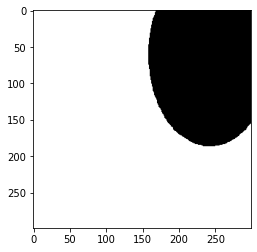

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

imshow(test_dataset[0][2], cmap='Greys')

In [ ]:
input = test_dataset[0][0][None,:,:,:].to(device)
model(input)

tensor([[ 1.0761, -0.9196]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
from sklearn.metrics import auc,average_precision_score, roc_curve,roc_auc_score,precision_recall_curve, f1_score

def get_output(model, dataset):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                             shuffle=False, num_workers=4)
    model = model.eval()
    y = []
    y_hat = []
    softmax= torch.nn.Softmax()
    with torch.no_grad() :
        for inputs, labels, cd in data_loader:
            y_hat.append((labels).cpu().numpy())
            y.append(torch.nn.Softmax(dim=1)( model(inputs.cuda()))[:,1].detach().cpu().numpy()) # take the probability for cancer
    y_hat = np.concatenate( y_hat, axis=0 )
    y = np.concatenate( y, axis=0 )
    return y, y_hat # in the training set the values were switched

def get_auc_f1(model, dataset,fname = None, ):
    if fname !=None:
        with open(fname, 'rb') as f:
            weights = torch.load(f)
        if "classifier.0.weight" in weights.keys(): #for the gradient models we unfortunately saved all of the weights
            model.load_state_dict(weights)
        else:
            model.classifier.load_state_dict(weights)
        y, y_hat = get_output(model.classifier, dataset)
    else:   
        y, y_hat = get_output(model, dataset)
    auc =roc_auc_score(y_hat, y)
    f1 = np.asarray([f1_score(y_hat, y > x) for x in np.linspace(0.1,1, num = 10) if (y >x).any() and (y<x).any()]).max()
    return auc, f1

In [ ]:
get_auc_f1(model, test_dataset)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(1.0, 1.0)

In [ ]:
out = get_output(model, test_dataset)

print(np.where(out[0] > 0.5))
print(np.where(out[1] == 1))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(array([ 30,  34,  37,  41,  43,  62,  71,  86, 101, 104, 110, 128, 153,
       171, 172, 176, 186, 196, 204, 206, 214]),)
(array([ 30,  34,  37,  41,  43,  62,  71,  86, 101, 104, 110, 128, 153,
       171, 172, 176, 186, 196, 204, 206, 214]),)


In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
print(models.vgg16(pretrained=True))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1